Run `pip install .` first to install all dependencies.

In [1]:
!pip install gcsfs==2022.10.0
!pip install wandb==0.13.4
!pip install fastparquet
!pip install numpy
!pip install pandas
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from catboost import CatBoostClassifier, Pool
import numpy as np

import gcsfs
import numpy as np
import pandas as pd

import wandb

from sklearn.preprocessing import MinMaxScaler


In [3]:
name = "classical_size_features_accuracy_branch"

# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

dataset = wandb.Artifact(name=name, type="preprocessed_data")


wandb: Currently logged in as: karelze (fbv). Use `wandb login --relogin` to force relogin


In [4]:
import google.auth
from google.colab import auth
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
#fs = gcsfs.GCSFileSystem(project="thesis")
fs = gcsfs.GCSFileSystem(project="thesis", credentials=credentials)

In [5]:
# reduce number of imported cols due to memory issues
columns = [
    "QUOTE_DATETIME",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]


In [86]:
train = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_extended_60.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)
val = pd.read_parquet(
    f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_extended_20.parquet",
    engine="fastparquet",
    columns=columns,
).sample(frac=0.1)

In [87]:
from sklearn.preprocessing import MinMaxScaler#QuantileTransformer

In [88]:
# oe_option_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_root = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )
# oe_issue_type = OrdinalEncoder(
#     unknown_value=-1, dtype=int, handle_unknown="use_encoded_value"
# )

scaler = MinMaxScaler(feature_range=[-1, 1])
# scaler = QuantileTransformer(n_quantiles=256)

def transform(data: pd.DataFrame) -> pd.DataFrame:

    # # date features
    x = pd.DataFrame(data={"TRADE_PRICE": data["TRADE_PRICE"]}, index=data.index)

    # log transformed features
    x[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex",
         ]
     ] = data[
         [
             "ask_ex",
             "bid_ex",
             "BEST_ASK",
             "BEST_BID",
             "TRADE_PRICE",
             "price_all_lag",
             "price_all_lead",
             "price_ex_lag",
             "price_ex_lead",
             "TRADE_SIZE", 
             "bid_size_ex", 
             "ask_size_ex"
         ]
     ]
    


    # x[(x["BEST_BID"] == 0) | (x["bid_ex"] == 0) | (x["bid_size_ex"] == 0)] = np.NaN
    x["bid_ex"].replace({0.0:np.NaN}, inplace=True)
    x["ask_ex"].replace({0.0:np.NaN}, inplace=True)
    # x[x["ask_ex"] == 0.0]["ask_ex"] = np.NaN
    # x[x["bid_ex"] == 0.0]["bid_ex"] = np.NaN

    # x["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
    # x["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

    # seconds_in_day = 24 * 60 * 60
    # seconds = (
    #     data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()
    # ).dt.total_seconds()

    # x["date_time_sin"] = np.sin(2 * np.pi * seconds / seconds_in_day)
    # x["date_time_cos"] = np.cos(2 * np.pi * seconds / seconds_in_day)

    # option features
    # x["ttm"] = (
    #     data["EXPIRATION"].dt.to_period("M") - data["QUOTE_DATETIME"].dt.to_period("M")
    # ).apply(lambda x: x.n)
    # x[["myn", "day_vol"]] = data[["myn", "day_vol"]]
    # x["log_strk_prc"] = np.log1p(data["STRK_PRC"])

    # binarize
    # "bin_OPTION_TYPE", "bin_issue_type", "bin_ROOT",

    # size features
    x["bid_ask_size_ratio_ex"] = x["bid_size_ex"] / x["ask_size_ex"]
    x["rel_bid_size_ex"] = x["TRADE_SIZE"] / x["bid_size_ex"]
    x["rel_ask_size_ex"] = x["TRADE_SIZE"] / x["ask_size_ex"]
     
    
    # classical
    mid_ex = 0.5 * (x["ask_ex"] + x["bid_ex"])
    mid_best = 0.5 * (x["BEST_ASK"] + x["BEST_BID"])
    #x["rel_ask_ex"] = (data["TRADE_PRICE"] - mid_ex) / (data["ask_ex"] - mid_ex)
    #x["rel_bid_ex"] = (mid_ex - data["TRADE_PRICE"]) / (mid_ex - data["bid_ex"])
    
    spread = (x["ask_ex"] - x["bid_ex"])
    
    # above_mid = (data["TRADE_PRICE"] > mid_ex)
    # above_mid_best = (data["TRADE_PRICE"] > mid_best)
    
    x["prox_ex"] = (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread) # , (data["TRADE_PRICE"] - mid_ex) / (0.5 * spread))  # combines rel. ask ex and bid ex 
    x["prox_best"] = (data["TRADE_PRICE"] - mid_best) / (0.5 * spread) #, (data["TRADE_PRICE"]- mid_best) / (0.5 * spread))    

    # x["BEST_rel_bid"] = (data["TRADE_PRICE"] - mid_best) / (data["BEST_ASK"] - mid_best)
    # x["BEST_rel_ask"] = (mid_best - data["TRADE_PRICE"]) / (mid_best - data["BEST_BID"])

    
    # x["prox_ex"].clip(-10,10, inplace=True)
    # x["prox_best"].clip(-10,10, inplace=True)
    
    # some uncovered comparsions
    # x["ask_ex_best_ratio"] = data["ask_ex"] / data["BEST_ASK"]
    # x["bid_ex_best_ratio"] = data["bid_ex"] / data["BEST_BID"]
    # x["mid_ex_best_ratio"] = mid_ex / mid_best
    x["ask_ex_best_ratio"] = x["ask_ex"]  / x["BEST_ASK"]
    x["bid_ex_best_ratio"] = x["bid_ex"]  / x["BEST_BID"]
    x["mid_ex_best_ratio"] = mid_ex  / mid_best
    
    x["bid_ask_ratio_ex"] = x["bid_ex"] / x["ask_ex"]
    # x["price_norm_size"] = data["TRADE_PRICE"] / data["TRADE_SIZE"]
    x["price_rel_nbb"] = (x["BEST_ASK"] - data["TRADE_PRICE"]) / (x["BEST_ASK"] - mid_best)
    x["price_rel_nbo"] = (data["TRADE_PRICE"] - x["BEST_BID"]) / (mid_best - x["BEST_BID"])
    # x["price_eq_ask_eq_bid"] = (data["TRADE_PRICE"] == data["ask_ex"]) & (data["TRADE_PRICE"] == data["bid_ex"])
    
    # calculate log returns
    x["chg_ex_lead"] = data["TRADE_PRICE"] - data["price_ex_lead"]
    x["chg_ex_lag"] = data["TRADE_PRICE"] - data["price_ex_lag"]
    x["chg_all_lead"] = data["TRADE_PRICE"] - data["price_all_lead"]
    x["chg_all_lag"] = data["TRADE_PRICE"] - data["price_all_lag"]


    # impute with zeros
    x.replace([np.inf, -np.inf], np.nan, inplace=True)
    x.fillna(-999, inplace=True)

    # # scale to [-1, 1]
    # if not hasattr(scaler, "n_features_in_"):
    #     scaler.fit(x)
    # x[x.columns] = scaler.transform(x)

    # https://stackoverflow.com/questions/70727291/how-do-i-know-whether-a-sklearn-scaler-is-already-fitted-or-not

    # if not hasattr(oe_option_type, "n_features_in_"):
    #     oe_option_type.fit(data["OPTION_TYPE"].astype(str).values.reshape(-1, 1))
    # x["bin_option_type"] = oe_option_type.transform(
    #     data["OPTION_TYPE"].astype(str).values.reshape(-1, 1)
    # )

    # if not hasattr(oe_root, "n_features_in_"):
    #     oe_root.fit(data["ROOT"].astype(str).values.reshape(-1, 1))
    # x["bin_root"] = oe_root.transform(data["ROOT"].astype(str).values.reshape(-1, 1))

    # if not hasattr(oe_issue_type, "n_features_in_"):
    #     oe_issue_type.fit(data["issue_type"].astype(str).values.reshape(-1, 1))
    # x["bin_issue_type"] = oe_issue_type.transform(
    #     data["issue_type"].astype(str).values.reshape(-1, 1)
    # )

    # x.replace([np.inf, -np.inf], np.nan, inplace=True)

    x["buy_sell"] = data["buy_sell"]
    return x


In [89]:
X_train = transform(train)
y_train = X_train.buy_sell
X_train.drop(columns=["buy_sell"], inplace=True)

del train

In [93]:
X_train[X_train["bid_ex"] == -999].head().T

,15084786,23269914,8127423,8510388,22246279
TRADE_PRICE,0.01,0.01,4.4,0.050000,0.030000
ask_ex,0.02,0.01,-999.0,0.050000,0.030000
bid_ex,-999.00,-999.00,-999.0,-999.000000,-999.000000
BEST_ASK,0.02,0.01,4.5,0.050000,0.030000
BEST_BID,0.00,0.00,4.3,0.000000,0.000000
price_all_lag,0.02,0.02,4.2,0.100000,0.020000
price_all_lead,-999.00,-999.00,3.9,-999.000000,-999.000000
price_ex_lag,0.02,0.02,4.2,0.100000,0.020000
price_ex_lead,-999.00,-999.00,3.5,-999.000000,-999.000000
TRADE_SIZE,20.00,18.00,5.0,1.000000,8.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17fbce43a0>,
      dtype=object)

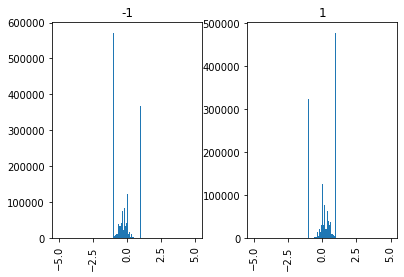

In [83]:
X_train.prox_ex.hist(bins=128, range=[-5,5], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f182811a3d0>,
      dtype=object)

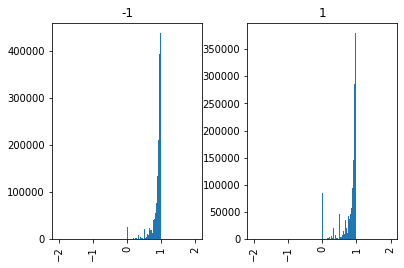

In [73]:
X_train["bid_ask_ratio_ex"].hist(bins=128, range=[-2,2], by=y_train)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f17fcce6520>,
      dtype=object)

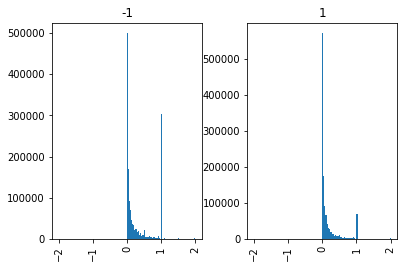

In [62]:
X_train["rel_ask_size_ex"].hist(bins=128, range=[-2,2], by=y_train)

In [46]:
X_train.shape

(2951032, 27)

In [72]:
X_train[X_train["bid_ex"]==-999].head().T

,9403795,8321773,9317925,16317387,6720338
TRADE_PRICE,0.50,1.950000,0.600000,4.650000,0.05
ask_ex,-999.00,-999.000000,-999.000000,-999.000000,-999.00
bid_ex,-999.00,-999.000000,-999.000000,-999.000000,-999.00
BEST_ASK,0.00,2.100000,0.600000,4.500000,0.20
BEST_BID,0.00,1.950000,0.550000,4.050000,0.05
price_all_lag,0.26,1.300000,0.500000,4.900000,0.20
price_all_lead,0.45,2.200000,0.550000,4.850000,0.15
price_ex_lag,0.26,1.300000,0.500000,2.710000,0.20
price_ex_lead,0.45,2.200000,0.550000,3.000000,0.15
TRADE_SIZE,10.00,2.000000,10.000000,20.000000,1.00


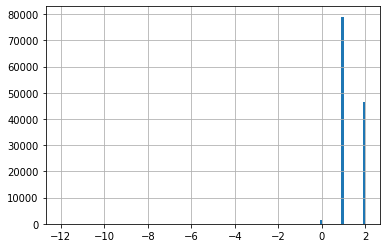

In [94]:
X_train["ask_size_ex"].hist(bins=128, range=[-12,2])

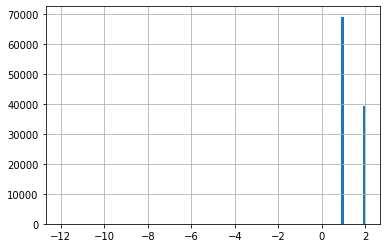

In [65]:
X_train["bid_size_ex"].hist(bins=128, range=[-12,2])

In [74]:
X_val = transform(val)
y_val = X_val.buy_sell
X_val.drop(columns=["buy_sell"], inplace=True)
del val

In [95]:
params = {
        "od_type": "Iter",
        "logging_level": "Silent",
        "loss_function": "Logloss",
        "task_type": "GPU",
        "cat_features": None,
        "random_seed": 42,
        "eval_metric":"Accuracy",
        "iterations":5000,
        "early_stopping_rounds":100,
        "grow_policy":"Lossguide"
}

#Lossguide, "grow_policy"

# lam = 0#0.25

#x = X_train.index.values / np.linalg.norm(X_train.index)
#x = (X_train.index.values - X_train.index.min()) / (X_train.index.max() - X_train.index.min())

# (v1-min(v1))/(max(v1)-min(v1))

#print(x)
# x = np.linspace(0,1, num=len(X_train))
#weight = np.exp(-lam * x)[::-1]
#weight = np.linspace(0,1, num=len(X_train))
#weight = np.geomspace(1e-4,1,num=len(X_train))
#print(weight)

model = CatBoostClassifier(**params)
train_pool = Pool(X_train, y_train,weight = X_train.index.values)
model.fit(train_pool, eval_set=(X_val,y_val))

print(model.score(X_val, y_val))

0.7436240382023729


In [ ]:
# 0.7434765583282902 without any scaler, zero imputer, symmetric tree
# 0.7445394305242655 "grow_policy" = "Lossguide" -> trained for 5000 iterations
# 0.7450428963013065 impute with -999 instead of 0 -> trained for 5000 iterations
# 0.7436240382023729 TODO: ask Caroline: What happens with LR if bid_ex = 0 or ask_ex is?   x["bid_ex"].replace({0.0:np.NaN}, inplace=True) and  x["ask_ex"].replace({0.0:np.NaN}, inplace=True)

In [ ]:
# 0.7333797810178145 (logs applied) to     x["bid_ask_size_ratio_ex"] x["rel_bid_size_ex"]   x["rel_ask_size_ex"] 
# 0.7331946683482763 (all from above + log returns)
# 0.734859665271541 (all above + compare mids, ask, and bid at exchange with nation wide)
# 0.7349013664773161 (all above + trade_price == bid_ex == ask_ex)
# 0.7351464881990674 (price normed size)
# 0.7352807457396116 (all above +  x["price_rel_nbo"] +  x["price_rel_nbb"])
# 0.74296292 (some removed, see above, max. iterations reached. Actually there is no reason to stop ensemble)
# 0.745053067 convert some ratios to percentages (all other things the same as above)
# robust scaler with log (ca. 74.4)
# robust scaler without log 0.74342061

# 0.74356606
# 0.74381220

In [ ]:
feature_importance = model.get_feature_importance(prettified=True)
feature_importance


In [ ]:
# 	Feature Id	Importances
# 0	ask_size_ex	12.525492
# 1	bid_size_ex	11.546952
# 2	rel_ask_ex	10.194505
# 3	bid_ask_size_ratio_ex	8.590138
# 4	rel_bid_ex	7.966504
# 5	rel_bid_size_ex	5.996297
# 6	BEST_rel_ask	4.807563
# 7	rel_ask_size_ex	4.260232
# 8	price_rel_nbo	3.670372
# 9	bid_ask_ratio_ex	3.384097
# 10	BEST_rel_bid	3.284908
# 11	price_rel_nbb	3.269674
# 12	TRADE_SIZE	3.073776
# 13	chg_all_lead	2.350704
# 14	chg_all_lag	1.966295
# 15	bid_ex_best_ratio	1.587316
# 16	ask_ex	1.578785
# 17	ask_ex_best_ratio	1.347937
# 18	chg_ex_lead	1.182017
# 19	TRADE_PRICE	1.073262
# 20	BEST_ASK	1.031167
# 21	bid_ex	0.923878
# 22	mid_ex_best_ratio	0.902499
# 23	BEST_BID	0.847981
# 24	price_all_lead	0.784676
# 25	chg_ex_lag	0.711833
# 26	price_ex_lead	0.594340
# 27	price_ex_lag	0.278488
# 28	price_all_lag	0.268311

In [ ]:
X_train.prox_ex.hist(bins=256)

In [ ]:
X_train.prox_ex.head(20)